In [1]:
#DS Final Project: Random Forest Model
##Shu Huang 11/23/2020

import pandas as pd
import numpy as np
file_source='https://raw.githubusercontent.com/RaterBai/DS-Project/master/prepared%20datasets/'

In [2]:
##Load full train & test datasets
train=pd.read_csv(file_source+'train.csv',dtype=str)
test=pd.read_csv(file_source+'test.csv',dtype=str)

In [3]:
# convert all binary values into integer
train.iloc[:,373:376]=train.iloc[:,373:376].astype(float).astype(int).astype(str)
test.iloc[:,373:376]=test.iloc[:,373:376].astype(float).astype(int).astype(str)
train=train.astype(int)
test=test.astype(int)

In [4]:
print('train', train.shape)
print('test', test.shape)

train (615, 377)
test (304, 377)


## Without Feature Selection

In [5]:
train_x=train.iloc[:,1:376]
train_y=train.iloc[:,376]
test_x=test.iloc[:,1:376]
test_y=test.iloc[:,376]

In [6]:
from collections import Counter
Counter(train_y),Counter(test_y)

(Counter({1: 513, 0: 102}), Counter({1: 254, 0: 50}))

In [7]:
102/513, 50/254
#the strafied split is successful since the 0/1 ratio is similar

(0.19883040935672514, 0.1968503937007874)

In [8]:
##without feature selection

# five-fold cross validation for parameter optimization: RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

def five_fold_RSCV(clf, params, dx, dy):
    cv_model = RandomizedSearchCV(clf, params, scoring='roc_auc', n_jobs=-1, 
                                  cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=13), 
                                  verbose=1, iid=True, n_iter=100, refit=True)
    
    cv_model.fit(dx, dy)
    y_pred=cv_model.predict(test_x)
    
    f1=f1_score(test_y, y_pred, average='weighted')
    balanced_accuracy=balanced_accuracy_score(test_y, y_pred)
    accuracy=accuracy_score(test_y, y_pred)
    precision=precision_score(test_y, y_pred, average='weighted')
    recall=recall_score(test_y, y_pred, average='weighted')
    auc=roc_auc_score(test_y, y_pred)
    matrix=confusion_matrix(test_y, y_pred)
    
    # performance
    print("F1 weighted: %1.4f" % f1)
    print("Balanced Accuracy: %1.4f" % balanced_accuracy)
    print("Accuracy: %1.4f" % accuracy)
    print("Precision weighted: %1.4f" % precision)
    print("Recall weighted: %1.4f" % recall)
    print("AUC weighted: %1.4f" % auc)
    print("Confusion matrix: ", matrix)
    
    return cv_model.best_estimator_, cv_model.best_score_ # best_score_: Mean cross-validated score of the best_estimator

In [9]:
# random forest without feature selection
rf = RandomForestClassifier(random_state=13)

# define search space
tuned_parameters = {'n_estimators':[50, 100, 250,  500, 750, 1000, 1250, 1500, 2000], 
                    'criterion':['gini', 'entropy'], 
                    'max_features':['log2', 'auto', None], 
                    'min_samples_split':[2, 3, 4], 
                    'max_depth': [3, 6, 9, 12, 15, 18, 21, 24, 32, None], 
                    'min_samples_leaf':[1, 2], 
                    'max_leaf_nodes': [None, 5, 10],
                    'min_impurity_decrease':[0.1, 0.01, 0.001, 0.0001, 0.00001],
                    'bootstrap': [True, False],
                    'class_weight': [None, 'balanced', 'balanced_subsample']}


best_rf_model, best_cv_performance = five_fold_RSCV(rf, tuned_parameters, train_x, train_y)
best_rf_model, best_cv_performance

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.7min finished


F1 weighted: 0.7496
Balanced Accuracy: 0.5916
Accuracy: 0.7336
Precision weighted: 0.7706
Recall weighted: 0.7336
AUC weighted: 0.5916
Confusion matrix:  [[ 19  31]
 [ 50 204]]


(RandomForestClassifier(bootstrap=True, class_weight='balanced',
                        criterion='gini', max_depth=18, max_features=None,
                        max_leaf_nodes=10, min_impurity_decrease=0.01,
                        min_impurity_split=None, min_samples_leaf=1,
                        min_samples_split=3, min_weight_fraction_leaf=0.0,
                        n_estimators=500, n_jobs=None, oob_score=False,
                        random_state=13, verbose=0, warm_start=False),
 0.6565486786710895)

In [10]:
# Top 15 features
importances = best_rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_rf_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the top 15 feature ranking
features=[]
importance=[]
print("Feature ranking top 15:")
for f in range(15):
    print("%d. %s (%f)" % (f + 1, train_x.columns[indices[f]], importances[indices[f]]))
    selected=train_x.columns[indices[f]]
    imp=importances[indices[f]]
    features.append(selected)
    importance.append(imp)

Feature ranking top 15:
1. drug_17 (0.101312)
2. drug_34 (0.076862)
3. 440409 (0.050294)
4. 432303 (0.047591)
5. drug_26 (0.046237)
6. 134398 (0.025801)
7. 74114 (0.024667)
8. drug_9 (0.023510)
9. 72413 (0.022748)
10. 75045 (0.020979)
11. 380397 (0.016964)
12. 443366 (0.016352)
13. 40480217 (0.015493)
14. gender (0.014596)
15. 196471 (0.014466)


In [11]:
imp_dict = {
    'feature' : features,
    'importance' : importance
}
df_imp = pd.DataFrame.from_dict(imp_dict)
df_imp = df_imp.sort_values(by = ['importance'], ascending=False)

# Plot the impurity-based feature importances of the forest
import matplotlib.pyplot as plt
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(15)  # change
ax.barh(y_pos, df_imp.importance, align = 'center', color = 'green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(df_imp.feature)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance (without feature selection)')
plt.show()

<Figure size 640x480 with 1 Axes>

In [12]:
# save model using pickle => binary saving method
import pickle as pkl

def save_pkl(data, file_name):
    with open(file_name, "wb") as f: # wb is write binary mode
        pkl.dump(data, f)
        
def load_pkl(file_name):
    with open(file_name, "rb") as f:
        data = pkl.load(f)
    return data

In [13]:
save_pkl(best_rf_model, "rf_model.pkl")
best_rf_model = load_pkl("rf_model.pkl")

In [14]:
# roc_auc score and plot
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

def plot_auc_roc(fpr, tpr):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = {:0.4f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (without feature selection)')
    plt.legend(loc="lower right")
    plt.show()

def get_Younden_idx(fpr, tpr, threshold):
    idx = np.argmax(np.abs(tpr-fpr))
    return threshold[idx]
    
def roc_auc_analysis(clf, dx, dy):
    preds = clf.predict_proba(dx) #predict: 0 or 1, predict_proba: [0.8, 0.2], predict probability for each class
    preds = list(map(lambda x: x[-1], preds))
    fpr, tpr, threshold = roc_curve(dy, preds)
    plot_auc_roc(fpr, tpr)
    print("first three predicted probabilities: ", preds[:3])
    print("roc_auc_score: ", roc_auc_score(dy, preds))
    J  = get_Younden_idx(fpr, tpr, threshold)
    print("Youden index: ", J)

    youden_preds = list(map(lambda x: 1 if x >= J else 0, preds))
    print("first three youden predicted results: ", youden_preds[:3])
    print("accuracy after apply youden index: ", accuracy_score(dy, youden_preds))
    
    if isinstance(clf, LogisticRegression):
        cof = clf.coef_.tolist()[0]
        cof_idx = list(zip(cof, range(len(cof)))) #get the coefficients
        top_5_fea = sorted(cof_idx, key=lambda x: abs(x[0]), reverse=True)[:5]
    elif isinstance(clf, RandomForestClassifier):
        fea_imp = clf.feature_importances_
        top_5_fea = sorted(list(zip(fea_imp, range(len(fea_imp)))), key=lambda x: abs(x[0]), reverse=True)[:5]
    else: # SVM
        # for SVM with RGB kernel, this is no straightforward way to get feature improtance
        # https://stats.stackexchange.com/questions/265656/is-there-a-way-to-determine-the-important-features-weight-for-an-svm-that-uses
        pass
        top_5_fea = []
    print("top 5 features: ", list(map(lambda x: (train_x.columns[x[1]], round(x[0], 4)), top_5_fea)))

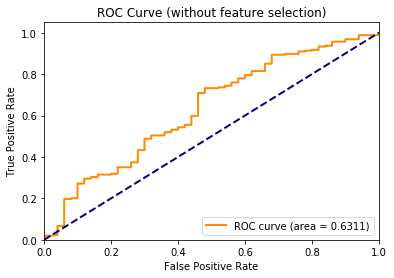

first three predicted probabilities:  [0.45251885598757186, 0.7822670729677355, 0.47912140603309195]
roc_auc_score:  0.6310629921259843
Youden index:  0.5525723054059193
first three youden predicted results:  [0, 1, 0]
accuracy after apply youden index:  0.6973684210526315
top 5 features:  [('drug_17', 0.1013), ('drug_34', 0.0769), ('440409', 0.0503), ('432303', 0.0476), ('drug_26', 0.0462)]


In [15]:
# RF ROC Curve
roc_auc_analysis(best_rf_model, test_x, test_y)

## With feature selection

In [16]:
##Get feature selected train & test datasets
train_sel=pd.read_csv(file_source+'train_after_selection.csv',dtype=str)

In [17]:
# convert all binary values into integer
train_sel.iloc[:,240:242]=train_sel.iloc[:,240:242].astype(float).astype(int).astype(str)
train_sel=train_sel.astype(int)

In [18]:
# created feature selected test dataset using train_sel column names
sel_top =list(train_sel.columns)
test_sel = test[sel_top]

In [19]:
print('train_sel', train_sel.shape)
print('test_sel', test_sel.shape)

train_sel (615, 243)
test_sel (304, 243)


In [20]:
train_xx=train_sel.iloc[:,0:242]
train_yy=train_sel.iloc[:,242]
test_xx=test_sel.iloc[:,0:242]
test_yy=test_sel.iloc[:,242]

In [21]:
##with feature selection

# five-fold cross validation for parameter optimization: RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

def five_fold_RSCV(clf, params, dx, dy):
    cv_model = RandomizedSearchCV(clf, params, scoring='roc_auc', n_jobs=-1, 
                                  cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=13), 
                                  verbose=1, iid=True, n_iter=100, refit=True)
    
    cv_model.fit(dx, dy)
    y_pred=cv_model.predict(test_xx)
    
    f1=f1_score(test_yy, y_pred, average='weighted')
    balanced_accuracy=balanced_accuracy_score(test_yy, y_pred)
    accuracy=accuracy_score(test_yy, y_pred)
    precision=precision_score(test_yy, y_pred, average='weighted')
    recall=recall_score(test_yy, y_pred, average='weighted')
    auc=roc_auc_score(test_yy, y_pred)
    matrix=confusion_matrix(test_yy, y_pred)
    
    # performance
    print("F1 weighted: %1.4f" % f1)
    print("Balanced Accuracy: %1.4f" % balanced_accuracy)
    print("Accuracy: %1.4f" % accuracy)
    print("Precision weighted: %1.4f" % precision)
    print("Recall weighted: %1.4f" % recall)
    print("AUC weighted: %1.4f" % auc)
    print("Confusion matrix: ", matrix)
    
    return cv_model.best_estimator_, cv_model.best_score_ # best_score_: Mean cross-validated score of the best_estimator

In [22]:
# random forest without feature selection
rf = RandomForestClassifier(random_state=13)

# define search space
tuned_parameters = {'n_estimators':[50, 100, 250,  500, 750, 1000, 1250, 1500, 2000], 
                    'criterion':['gini', 'entropy'], 
                    'max_features':['log2', 'auto', None], 
                    'min_samples_split':[2, 3, 4], 
                    'max_depth': [3, 6, 9, 12, 15, 18, 21, 24, 32, None], 
                    'min_samples_leaf':[1, 2], 
                    'max_leaf_nodes': [None, 5, 10],
                    'min_impurity_decrease':[0.1, 0.01, 0.001, 0.0001, 0.00001],
                    'bootstrap': [True, False],
                    'class_weight': [None, 'balanced', 'balanced_subsample']}


best_rf_model, best_cv_performance = five_fold_RSCV(rf, tuned_parameters, train_xx, train_yy)
best_rf_model, best_cv_performance

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.0min finished


F1 weighted: 0.6728
Balanced Accuracy: 0.5607
Accuracy: 0.6283
Precision weighted: 0.7545
Recall weighted: 0.6283
AUC weighted: 0.5607
Confusion matrix:  [[ 23  27]
 [ 86 168]]


(RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                        criterion='gini', max_depth=6, max_features=None,
                        max_leaf_nodes=10, min_impurity_decrease=0.001,
                        min_impurity_split=None, min_samples_leaf=2,
                        min_samples_split=2, min_weight_fraction_leaf=0.0,
                        n_estimators=1500, n_jobs=None, oob_score=False,
                        random_state=13, verbose=0, warm_start=False),
 0.6709175797558742)

In [23]:
# Top 15 features
importances = best_rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_rf_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the top 15 feature ranking
features=[]
importance=[]
print("Feature ranking top 15:")
for f in range(15):
    print("%d. %s (%f)" % (f + 1, train_xx.columns[indices[f]], importances[indices[f]]))
    selected=train_xx.columns[indices[f]]
    imp=importances[indices[f]]
    features.append(selected)
    importance.append(imp)

Feature ranking top 15:
1. 40480217 (0.212581)
2. drug_34 (0.171960)
3. 440409 (0.147500)
4. drug_17 (0.138329)
5. 432303 (0.099284)
6. 372624 (0.089419)
7. drug_13 (0.075659)
8. 44782549 (0.065268)
9. drug_15 (0.000000)
10. 440987 (0.000000)
11. 78472 (0.000000)
12. 74373 (0.000000)
13. 381572 (0.000000)
14. 195197 (0.000000)
15. 440940 (0.000000)


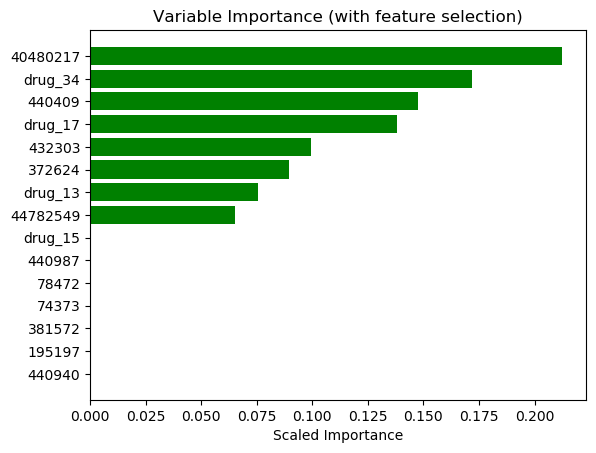

In [24]:
imp_dict = {
    'feature' : features,
    'importance' : importance
}
df_imp = pd.DataFrame.from_dict(imp_dict)
df_imp = df_imp.sort_values(by = ['importance'], ascending=False)

# Plot the impurity-based feature importances of the forest
import matplotlib.pyplot as plt
plt.rcdefaults()
fig, ax = plt.subplots()
y_pos = np.arange(15)  # change
ax.barh(y_pos, df_imp.importance, align = 'center', color = 'green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(df_imp.feature)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance (with feature selection)')
plt.show()

In [25]:
save_pkl(best_rf_model, "rf_model.pkl")
best_rf_model = load_pkl("rf_model.pkl")

In [26]:
# roc_auc score and plot
def plot_auc_roc(fpr, tpr):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = {:0.4f})'.format(auc(fpr, tpr)))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (with feature selection)')
    plt.legend(loc="lower right")
    plt.show()

def get_Younden_idx(fpr, tpr, threshold):
    idx = np.argmax(np.abs(tpr-fpr))
    return threshold[idx]
    
def roc_auc_analysis(clf, dx, dy):
    preds = clf.predict_proba(dx) #predict: 0 or 1, predict_proba: [0.8, 0.2], predict probability for each class
    preds = list(map(lambda x: x[-1], preds))
    fpr, tpr, threshold = roc_curve(dy, preds)
    plot_auc_roc(fpr, tpr)
    print("first three predicted probabilities: ", preds[:3])
    print("roc_auc_score: ", roc_auc_score(dy, preds))
    J  = get_Younden_idx(fpr, tpr, threshold)
    print("Youden index: ", J)

    youden_preds = list(map(lambda x: 1 if x >= J else 0, preds))
    print("first three youden predicted results: ", youden_preds[:3])
    print("accuracy after apply youden index: ", accuracy_score(dy, youden_preds))
    
    if isinstance(clf, LogisticRegression):
        cof = clf.coef_.tolist()[0]
        cof_idx = list(zip(cof, range(len(cof)))) #get the coefficients
        top_5_fea = sorted(cof_idx, key=lambda x: abs(x[0]), reverse=True)[:5]
    elif isinstance(clf, RandomForestClassifier):
        fea_imp = clf.feature_importances_
        top_5_fea = sorted(list(zip(fea_imp, range(len(fea_imp)))), key=lambda x: abs(x[0]), reverse=True)[:5]
    else: # SVM
        # for SVM with RGB kernel, this is no straightforward way to get feature improtance
        # https://stats.stackexchange.com/questions/265656/is-there-a-way-to-determine-the-important-features-weight-for-an-svm-that-uses
        pass
        top_5_fea = []
    print("top 5 features: ", list(map(lambda x: (train_xx.columns[x[1]], round(x[0], 4)), top_5_fea)))

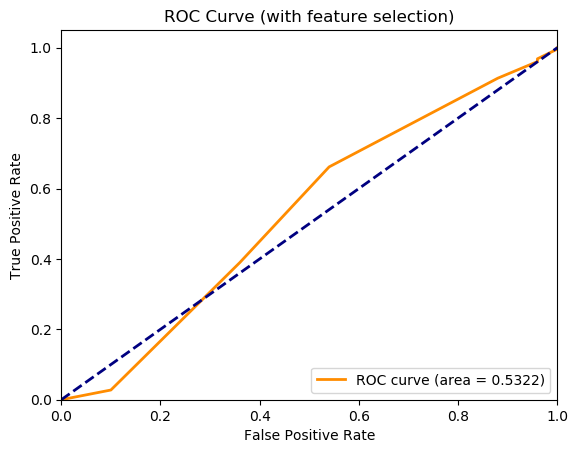

first three predicted probabilities:  [0.28072908552735065, 0.8076009501187459, 0.26714285714285774]
roc_auc_score:  0.5322047244094488
Youden index:  0.6055868785238169
first three youden predicted results:  [0, 1, 0]
accuracy after apply youden index:  0.6282894736842105
top 5 features:  [('40480217', 0.2126), ('drug_34', 0.172), ('440409', 0.1475), ('drug_17', 0.1383), ('432303', 0.0993)]


In [27]:
# RF ROC Curve
roc_auc_analysis(best_rf_model, test_xx, test_yy)